# Кластеризация на примере задачи размещения баннеров

Международное круизное агентство Carnival Cruise Line решило себя разрекламировать с помощью баннеров и обратилось для этого к вам. Чтобы протестировать, велика ли от таких баннеров польза, их будет размещено всего 20 штук по всему миру. Вам надо выбрать 20 таких локаций для размещения, чтобы польза была большой и агентство продолжило с вами сотрудничать.

Агентство крупное, и у него есть несколько офисов по всему миру. Вблизи этих офисов оно и хочет разместить баннеры — легче договариваться и проверять результат. Также эти места должны быть популярны среди туристов.

**1. Для поиска оптимальных мест воспользуемся базой данных крупнейшей социальной сети, основанной на локациях — Foursquare.**

Часть открытых данных есть на сайте archive.org:
https://archive.org/details/201309_foursquare_dataset_umn

In [1]:
%matplotlib inline

import matplotlib
matplotlib.style.use('ggplot')

from matplotlib import pyplot
from matplotlib.colors import ListedColormap

from sklearn import model_selection, datasets, linear_model, metrics
from sklearn.cluster import MeanShift

import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('checkins.csv', header = 0, sep = '|', skipinitialspace=True)

In [3]:
# Удалить пробелы в наименованиях столбцов
data.columns = data.columns.str.strip()

In [4]:
# Проверка наличия пропущенных значений в датасете
data.isnull().values.any()

True

Удалим строки, не содержащие координат — они неинформативны

In [5]:
#  Исключение всех данных, у которых пропущено хотя бы одно значение
data = data.dropna()

In [6]:
data.shape

(396634, 6)

In [7]:
data.columns

Index(['id', 'user_id', 'venue_id', 'latitude', 'longitude', 'created_at'], dtype='object')

In [8]:
# Преобразование данные столбца datetime к формату pandas created_at
data.created_at = data.created_at.apply(pd.to_datetime)

In [9]:
# Сводная информация о датасете
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 396634 entries, 1 to 1021964
Data columns (total 6 columns):
id            396634 non-null int64
user_id       396634 non-null int64
venue_id      396634 non-null int64
latitude      396634 non-null float64
longitude     396634 non-null float64
created_at    396634 non-null datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(3)
memory usage: 21.2 MB


In [10]:
data

,id,user_id,venue_id,latitude,longitude,created_at
1,984222,15824,5222,38.895112,-77.036366,2012-04-21 17:43:47
3,984234,44652,5222,33.800745,-84.410520,2012-04-21 17:43:43
7,984291,105054,5222,45.523452,-122.676207,2012-04-21 17:39:22
9,984318,2146539,5222,40.764462,-111.904565,2012-04-21 17:35:46
10,984232,93870,380645,33.448377,-112.074037,2012-04-21 17:38:18
...,...,...,...,...,...,...
1021959,955561,626076,20073,40.850100,-73.866246,2012-04-13 09:56:48
1021960,955892,674797,2297,33.748995,-84.387982,2012-04-13 10:56:03
1021961,956377,845102,11195,42.765366,-71.467566,2012-04-13 12:08:45
1021962,956119,1139114,29488,42.439479,-83.743830,2012-04-13 11:36:44


**2. Теперь необходимо кластеризовать данные координаты, чтобы выявить центры скоплений туристов. Поскольку баннеры имеют сравнительно небольшую площадь действия, нам нужен алгоритм, позволяющий ограничить размер кластера и не зависящий от количества кластеров.**

Для данной задачи можно воспользоваться алгоритмом [MeanShift](https://scikit-learn.org/stable/modules/clustering.html#mean-shift). 

Параметр bandwidth=0.1, что в переводе из градусов в метры колеблется примерно от 5 до 10 км в средних широтах.

In [11]:
X = np.array(data[['latitude', 'longitude']])

In [12]:
X.shape

(396634, 2)

In [13]:
%%time

# bandwidth=0.1, что в переводе из градусов в метры колеблется примерно от 5 до 10 км в средних широтах
ms = MeanShift(bandwidth=0.1, n_jobs=-1)
ms.fit(X)

Wall time: 16min 28s


MeanShift(bandwidth=0.1, bin_seeding=False, cluster_all=True, min_bin_freq=1,
          n_jobs=-1, seeds=None)

In [14]:
labels = ms.labels_
cluster_centers = ms.cluster_centers_

print("number of estimated clusters : %d" % len(np.unique(labels)))

number of estimated clusters : 5536


**3. Некоторые из получившихся кластеров содержат слишком мало точек — такие кластеры не интересны рекламодателям. Поэтому определим, какие из кластеров содержат, скажем, больше 15 элементов. Центры этих кластеров и являются оптимальными для размещения.**

In [15]:
n = 15 # Размер кластера

labels_list = []
centers_list = []

for label, center in zip(np.unique(labels), cluster_centers):
    if labels[labels == label].shape[0] > n:
        labels_list.append(label)
        centers_list.append(center)

**4. Получившиеся результаты можно отобразить на карте. Например, сайт [mapcustomizer.com](https://www.mapcustomizer.com/) имеет функцию Bulk Entry, куда можно вставить центры полученных кластеров.**

In [16]:
# Генерация координат для отображения на сайте mapcustomizer.com (функция Bulk Entry)

for i in centers_list:
    print(f'{i[0]},{i[1]}')

40.7174845862584,-73.98935882808821
33.44969472443301,-112.00256309983916
41.878164547478406,-87.62982710147185
33.446828092976624,-111.90253316837602
38.88610691488046,-77.04819943136073
37.686017626172365,-122.40905969058612
37.78608129133564,-122.42389025911206
33.768093404116925,-84.39337919529437
42.3629793130329,-71.07447328375903
47.6064012884944,-122.33204020212654
33.357166690884405,-111.82247998341624
34.064978390568754,-118.26547835472107
44.97769676931425,-93.26803824334303
36.11722275654821,-115.17118076175403
30.267265080765355,-97.74301837147084
39.95214463544053,-75.16362052658629
40.76946326482607,-73.83786060145177
32.98103799191494,-117.07827224773314
34.033593772369166,-118.43659122548848
39.73504691357897,-104.98846199668517
28.543021660599123,-81.37655310719285
32.803120685044775,-96.76982401051944
34.12886630190464,-118.3523977511818
43.04080324202834,-87.9132222462788
25.787086104201528,-80.21512757233921
-6.212296265130904,106.84363532227688
29.762314817710735,

43.09926379523808,-78.72032319523811
41.72869285714287,-70.61722700000003
41.68199349999999,-85.9766671
41.02368488571428,-72.48560254285717
40.53044873809525,-75.57733326666664
40.38916317142856,-82.46461945714285
39.548935000000014,-89.294533
39.19240354285713,-120.2226395714286
38.301478114285715,-76.46454545238096
37.765281200000004,-84.28996132857141
37.368403014285704,-77.47784238571427
35.758440714285705,-86.92734351428572
35.388344761904754,-94.3961532380952
35.0886963,-92.44210109999996
35.04203600000001,-89.66452660000002
34.50083110000001,-117.1858759
34.24166477619047,-116.91396644285712
33.525942257142866,-82.10448360476192
33.016943119047625,-80.17251306190475
29.80452284761905,-85.29464613333333
28.248901600000003,-81.28118010000001
26.44629778571428,-81.98015003333336
-7.443729952380951,112.74224933333339
47.24874899999998,-121.68548159999997
47.154031245,-122.55412609999999
46.80832680000001,-100.78373919999996
45.39667603999998,-84.96999744000001
44.23483778000003,-72

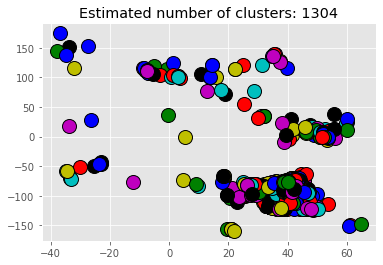

In [17]:
# Визуализация результатов

from itertools import cycle

pyplot.figure(1)
pyplot.clf()

colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(labels_list, colors):
    my_members = labels == k
    cluster_center = cluster_centers[k]
    pyplot.plot(X[my_members, 0], X[my_members, 1], col + '.')
    pyplot.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=14)
pyplot.title('Estimated number of clusters: %d' % len(labels_list))
pyplot.show()

In [18]:
# Перевод массивов в NumPy
centers_list = np.array(centers_list)
labels_list = np.array(labels_list)

def nearest_obj(obj:list, k:int, office:str):
    
    """Возвращает k ближайших точек"""
    
    # Вектор исходного объекта
    obj_n = np.array(obj * len(centers_list))
    obj_n = obj_n.reshape((len(centers_list), 2))
    
    # Вектор наименований офисов
    name = np.array([office]*len(centers_list))
    
    # Вычисление вектора расстояний
    d = ((centers_list[:,0] - obj_n[:,0])**2 + (centers_list[:,1] - obj_n[:,1])**2)**0.5
    
    # Объединение исходных матриц
    dd = np.vstack((labels_list, centers_list[:,0], centers_list[:,1], d, name)).T
    
    # Сортировка элементов по расстоянию
    dd = dd[dd[:,3].argsort()]
    
    # Вывод k ближайших элементов (dd[:k,:])
    print(f'\n#Cluster\tlatitude\tlongitude\tdistance\toffice\n')
    for i in range(k):
        print(f'{int(dd[i,0])}\t\t{float(dd[i,1]):.6f}\t{float(dd[i,2]):.6f}\t{float(dd[i,3]):.6f}\t{str(dd[i,4])}')
        
    return dd[:k,:]

**5. Найдем на Google Maps по запросу Carnival Cruise Line адреса всех офисов компании.**

In [19]:
objs = {'Los Angeles':[33.751277, -118.188740], 
        'Miami':[25.867736, -80.324116],
        'London':[51.503016, -0.075479],
        'Amsterdam':[52.378894, 4.885084],
        'Beijing':[39.366487, 117.036146],
        'Sydney':[-33.868457, 151.205134],}

**6. Определим 20 ближайших к офисам компании центров кластеров. Т.е. посчитаем дистанцию до ближайшего офиса для каждой точки и выберем 20 с наименьшим значением.**

Поскольку важно определить кластеры вблизи офисов, расстояние между ними сравнительно мало, можно пренебречь тем, что Земля круглая. Погрешность при подсчете дистанций в данном случае мала.

In [20]:
# distance = np.zeros((20, 4))
distance = []

for obj in objs:
    matrix = nearest_obj(obj=objs[obj], k=20, office=obj)
    distance.append(matrix)

distance = np.vstack((distance[0], distance[1], distance[2], distance[3], distance[4], distance[5]))

# Сортировка элементов по расстоянию
distance = distance[distance[:,3].argsort()]


#Cluster	latitude	longitude	distance	office

48		33.811275	-118.144334	0.074644	Los Angeles
79		33.898488	-118.062259	0.194084	Los Angeles
36		33.922035	-118.414390	0.282978	Los Angeles
31		33.816965	-117.893695	0.302269	Los Angeles
11		34.064978	-118.265478	0.322951	Los Angeles
32		33.675235	-117.854455	0.342825	Los Angeles
66		34.070046	-118.023957	0.358841	Los Angeles
97		34.011356	-117.921505	0.372901	Los Angeles
18		34.033594	-118.436591	0.375677	Los Angeles
53		34.127295	-118.121813	0.381927	Los Angeles
22		34.128866	-118.352398	0.411531	Los Angeles
40		34.160986	-118.233667	0.412165	Los Angeles
139		34.070037	-117.811069	0.494209	Los Angeles
49		34.188022	-118.446287	0.507027	Los Angeles
91		33.575306	-117.710220	0.509851	Los Angeles
111		34.050804	-117.696196	0.576469	Los Angeles
75		34.197994	-118.553189	0.576523	Los Angeles
252		33.472855	-117.662245	0.595580	Los Angeles
293		33.880908	-117.564651	0.637410	Los Angeles
436		34.005008	-118.810089	0.671159	Los Angeles

#Cluster

In [21]:
print(f'\n#Cluster\tlatitude\tlongitude\tdistance\n')
for i in range(20):
    print(f'{int(distance[i,0])}\t\t{float(distance[i,1]):.6f}\t{float(distance[i,2]):.6f}\t{float(distance[i,3]):.6f}\t{str(distance[i,4])}')


#Cluster	latitude	longitude	distance

251		-33.866146	151.207082	0.003023	Sydney
319		52.372489	4.892268	0.009625	Amsterdam
317		25.846206	-80.311245	0.025084	Miami
55		51.503055	-0.127113	0.051634	London
48		33.811275	-118.144334	0.074644	Los Angeles
24		25.787086	-80.215128	0.135583	Miami
98		26.005052	-80.205598	0.181390	Miami
79		33.898488	-118.062259	0.194084	Los Angeles
849		51.480366	-0.308323	0.233944	London
964		51.598314	-0.321786	0.264100	London
461		26.139268	-80.336708	0.271824	Miami
36		33.922035	-118.414390	0.282978	Los Angeles
51		26.108543	-80.158582	0.292215	Miami
31		33.816965	-117.893695	0.302269	Los Angeles
11		34.064978	-118.265478	0.322951	Los Angeles
32		33.675235	-117.854455	0.342825	Los Angeles
159		26.202449	-80.244158	0.344131	Miami
66		34.070046	-118.023957	0.358841	Los Angeles
982		52.081999	5.096392	0.364414	Amsterdam
97		34.011356	-117.921505	0.372901	Los Angeles


**7. Получены коорднаты 20 самых популярных мест вблизи офисов компании.**